1. Do the labels look right? (random grids per class)
2. Are there obvious bad samples? (corrupt, blank, non-face, weird crops)
3. What are “outliers” by simple image metrics? (too dark / too blurry / too low contrast)

Config

In [2]:
from _bootstrap import bootstrap
bootstrap()

from xai_lab.utils.paths import find_project_root, resolve_path

PROJECT_ROOT = find_project_root()


Load CSV + resolve paths robustly

In [3]:
import pandas as pd

df = pd.read_csv(CSV_PATH)

# basic cleanup
df[COL_PATH] = df[COL_PATH].astype(str).str.strip()
if COL_LABEL_NAME in df.columns:
    df[COL_LABEL_NAME] = df[COL_LABEL_NAME].astype(str).str.strip()

def resolve_path(p: str) -> Path:
    pth = Path(str(p))
    return pth if pth.is_absolute() else (PROJECT_ROOT / pth)

df["resolved_path"] = df[COL_PATH].map(resolve_path)

# minimal validity checks
assert "resolved_path" in df.columns
missing = df.loc[~df["resolved_path"].map(lambda p: p.exists())]
print("Rows:", len(df), "| Missing files:", len(missing))
missing.head()

Rows: 686 | Missing files: 0


,path,label,label_name,width,height,mode,sha1,resolved_path


Decide what we call "class"

In [5]:
if COL_LABEL_NAME in df.columns:
    df["class"] = df[COL_LABEL_NAME]
elif COL_LABEL_ID in df.columns:
    df["class"] = df[COL_LABEL_ID].astype(str)
else:
    raise ValueError("Need either label_name or label column in the CSV.")

classes = sorted(df["class"].unique().tolist())
print("Num classes:", len(classes))
classes[:10]

Num classes: 7


['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [8]:
df.head()

,path,label,label_name,width,height,mode,sha1,resolved_path,class
0,data/raw/ckplus/happy/S078_004_00000027.png,4,happy,48,48,L,b8cf9e957093b01e482005a1c47c514c72861e28,D:\Kebench\Documents\projects\xai-lab\data\raw...,happy
1,data/raw/ckplus/sadness/S080_005_00000011.png,5,sadness,48,48,L,54c7b1b5cf50c23cda4b4b6fe76fed4ffb639374,D:\Kebench\Documents\projects\xai-lab\data\raw...,sadness
2,data/raw/ckplus/happy/S100_006_00000015.png,4,happy,48,48,L,5382e1c188577cb99e0d8c1c06f5551600ddb152,D:\Kebench\Documents\projects\xai-lab\data\raw...,happy
3,data/raw/ckplus/sadness/S138_007_00000009.png,5,sadness,48,48,L,9168e33c06eaf8bd31c87efb42c8e915604bfa3a,D:\Kebench\Documents\projects\xai-lab\data\raw...,sadness
4,data/raw/ckplus/anger/S050_004_00000021.png,0,anger,48,48,L,ba8ea832e8c1feaf480996a441bafff3f172923b,D:\Kebench\Documents\projects\xai-lab\data\raw...,anger


Quick visual grid per class (label sanity)

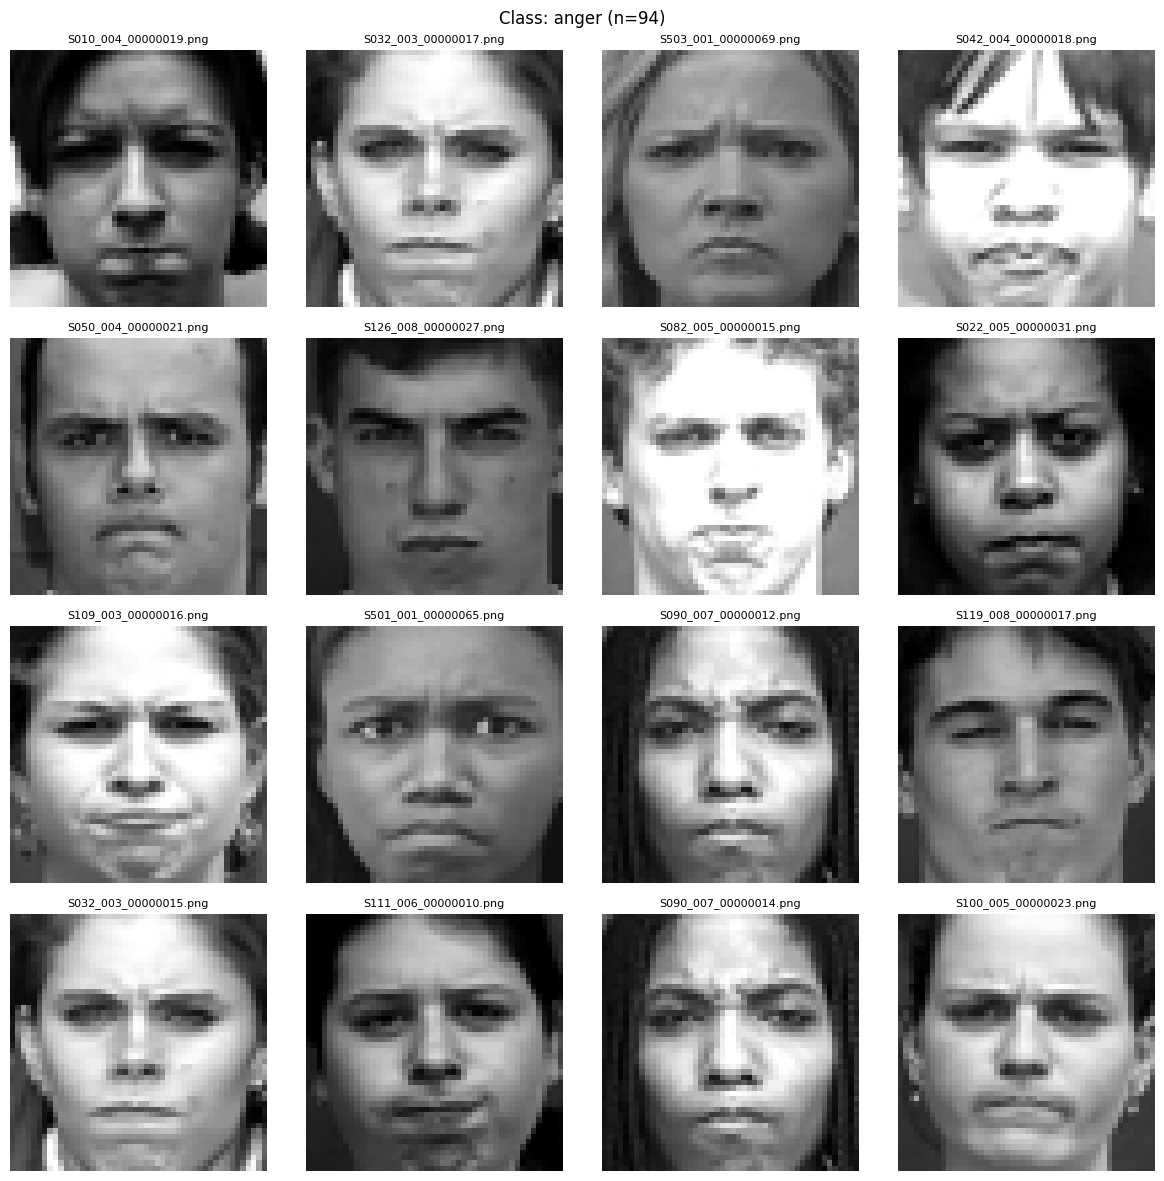

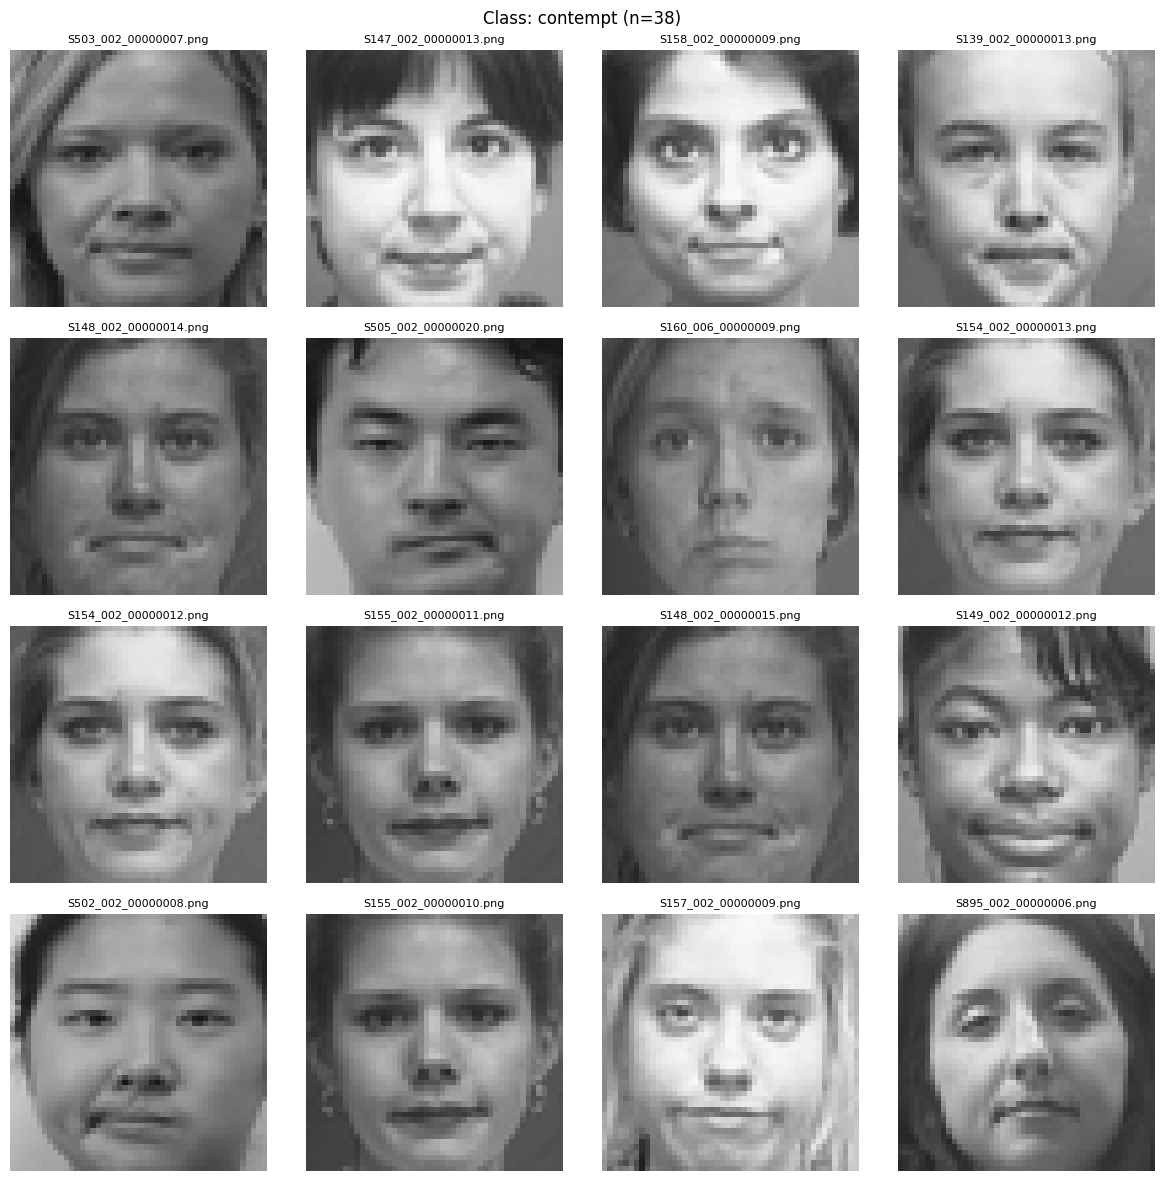

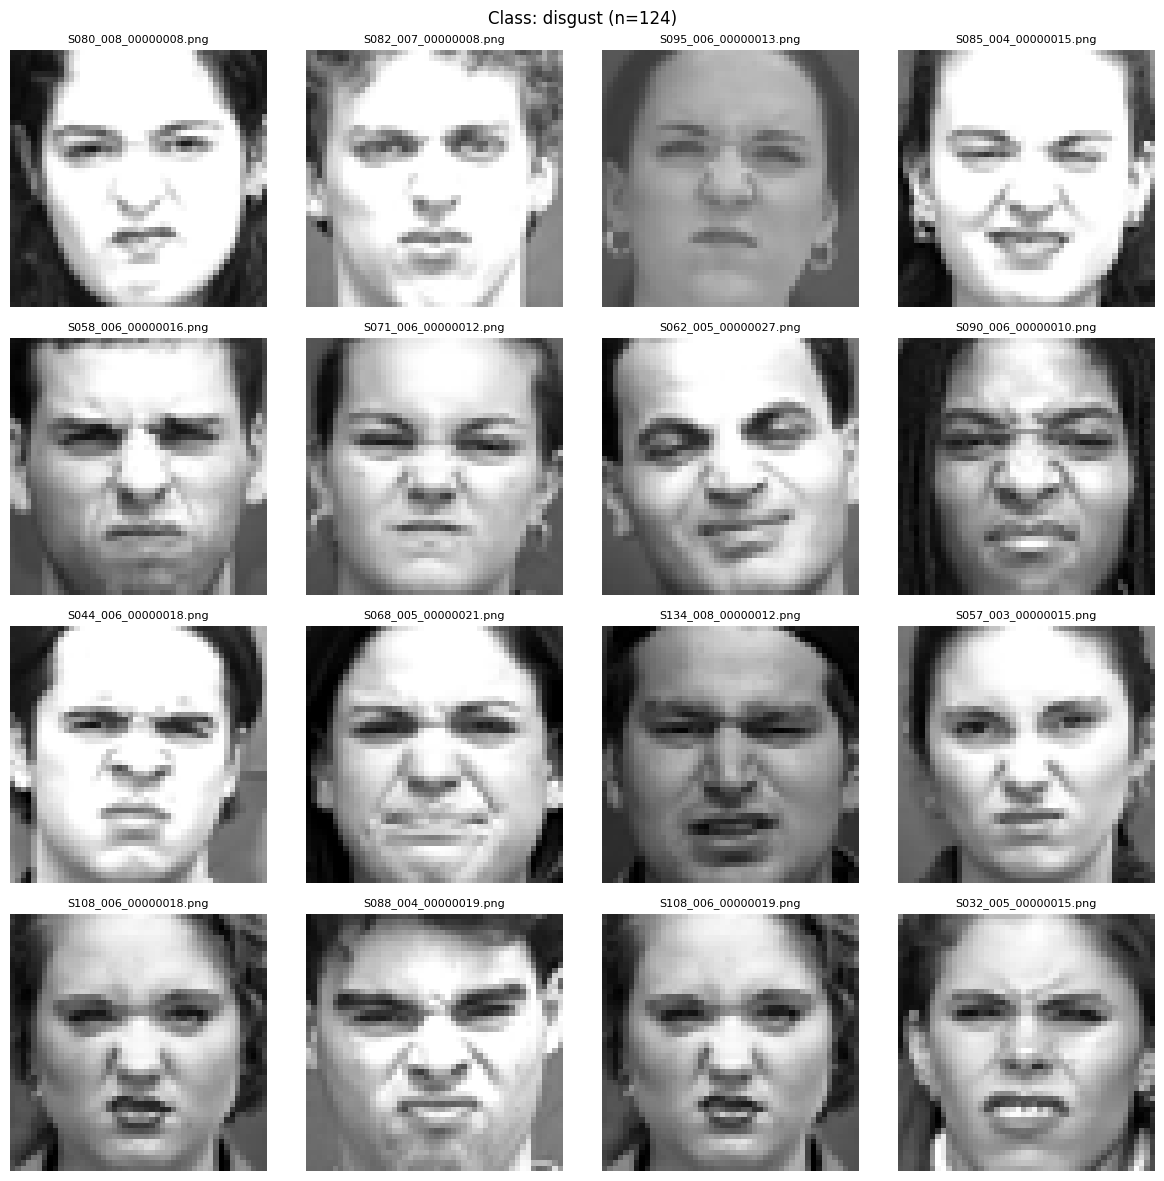

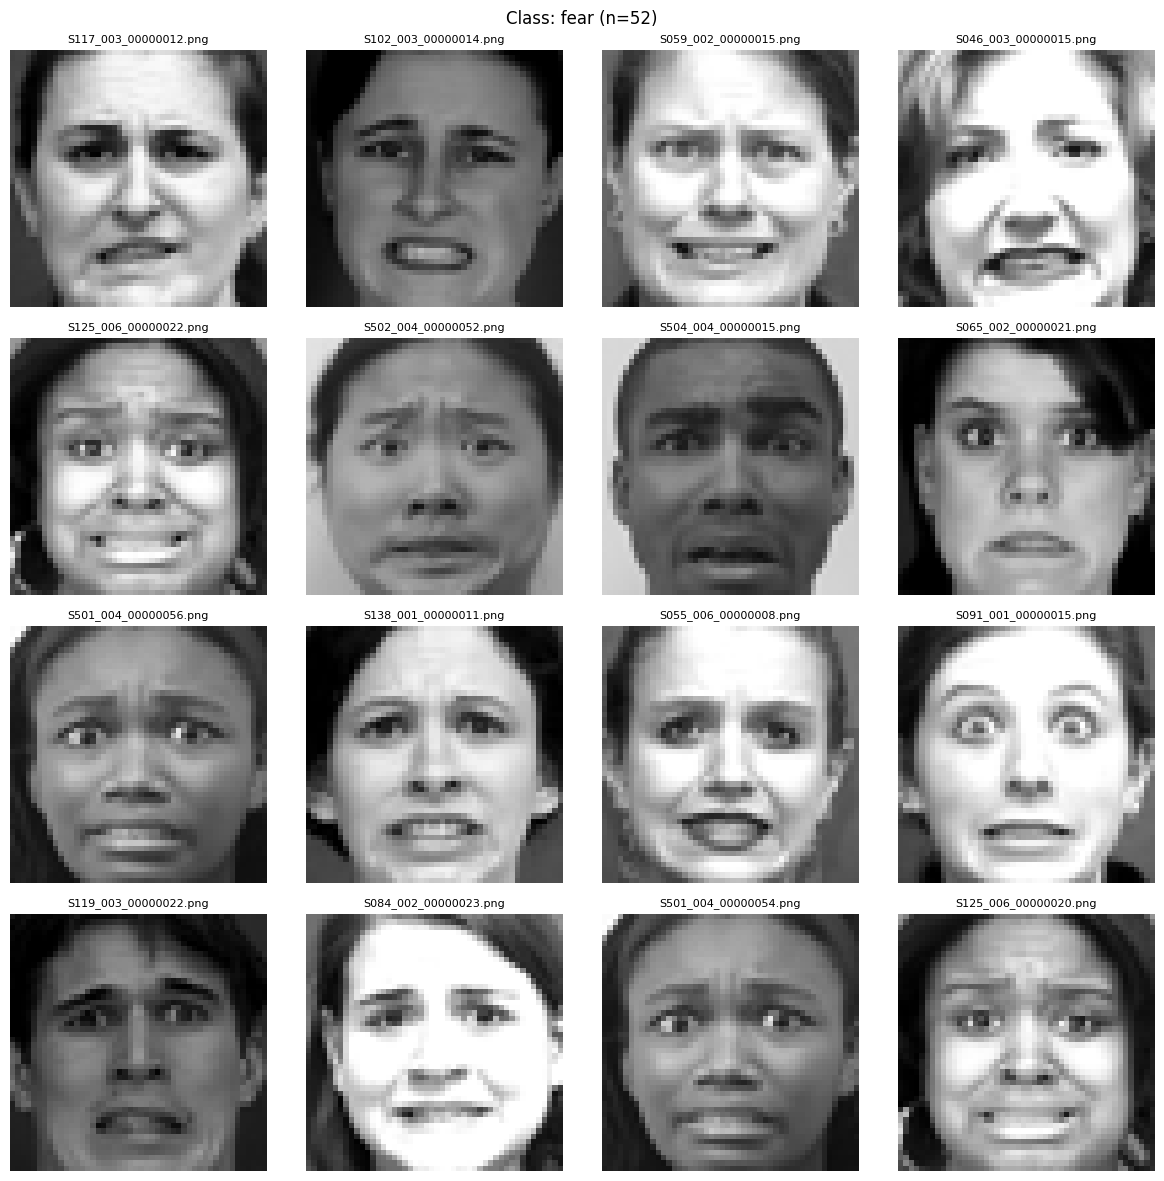

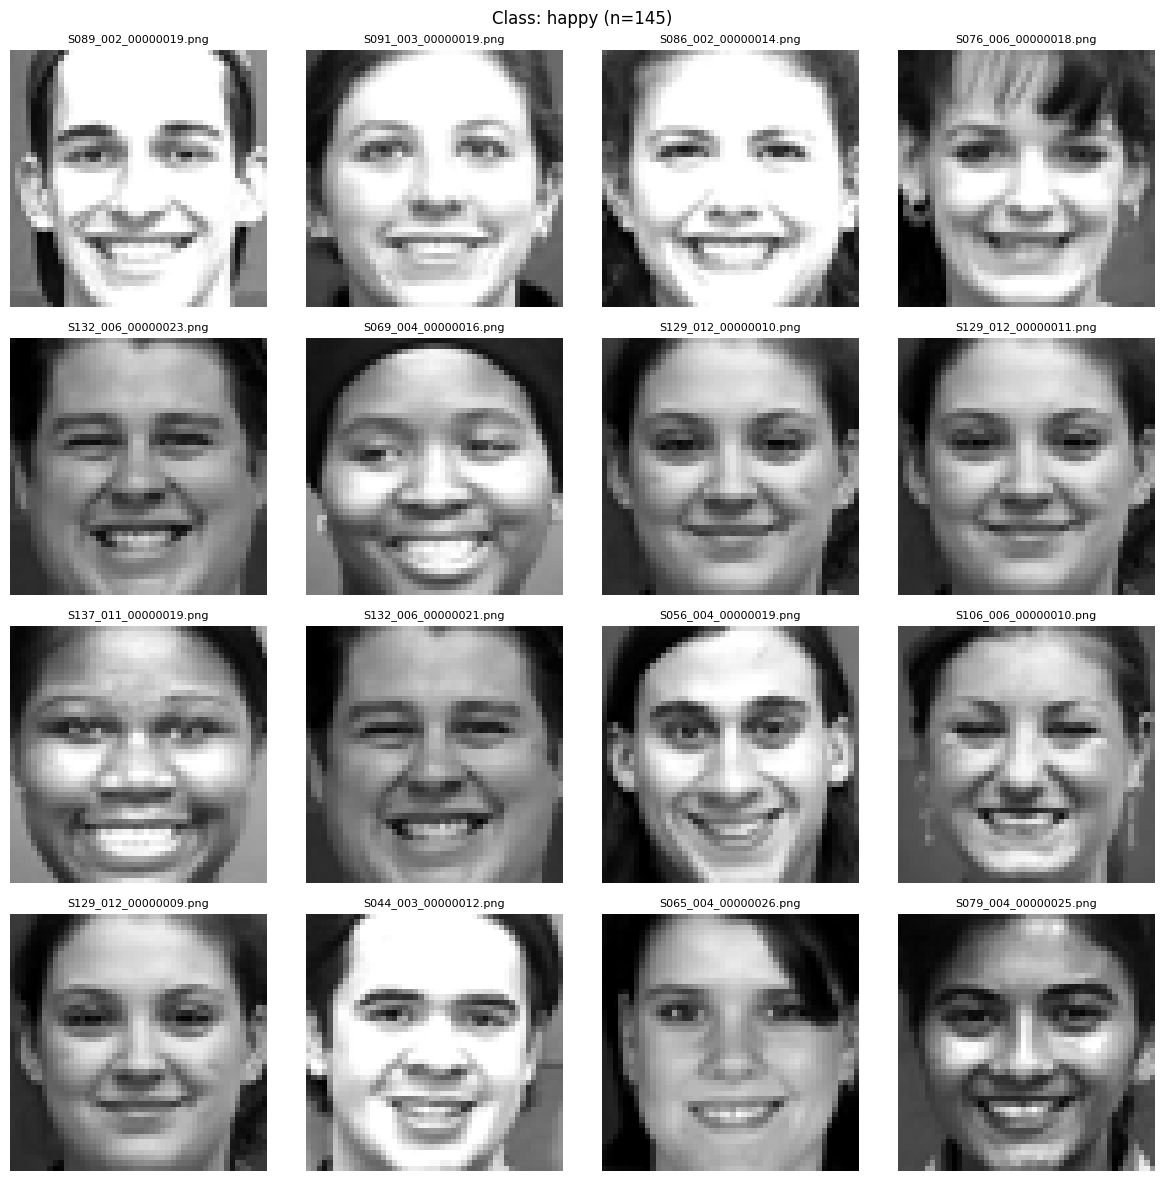

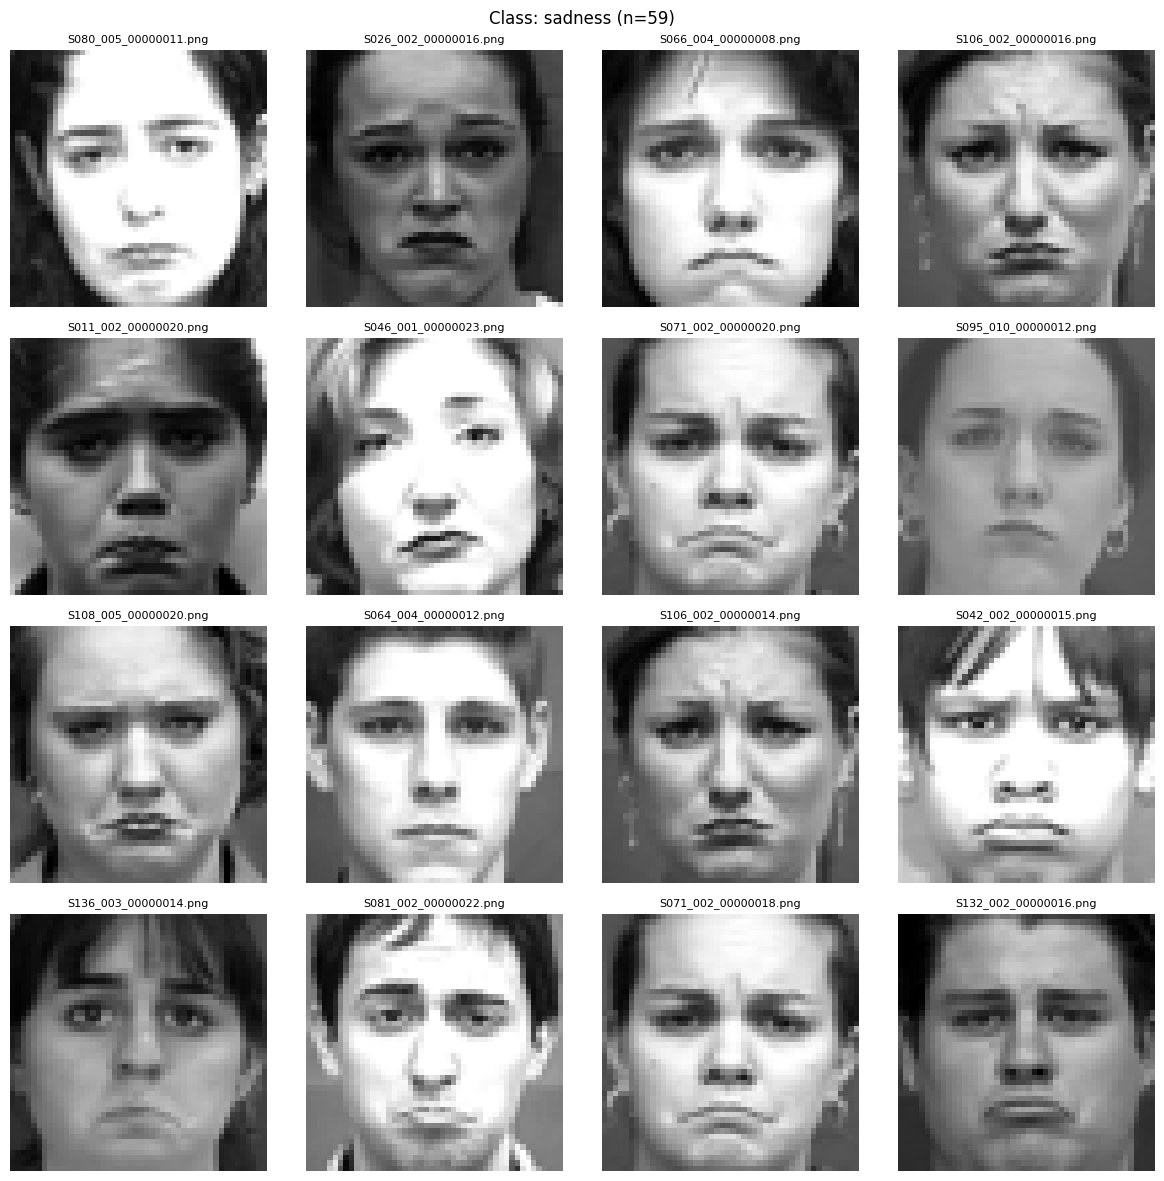

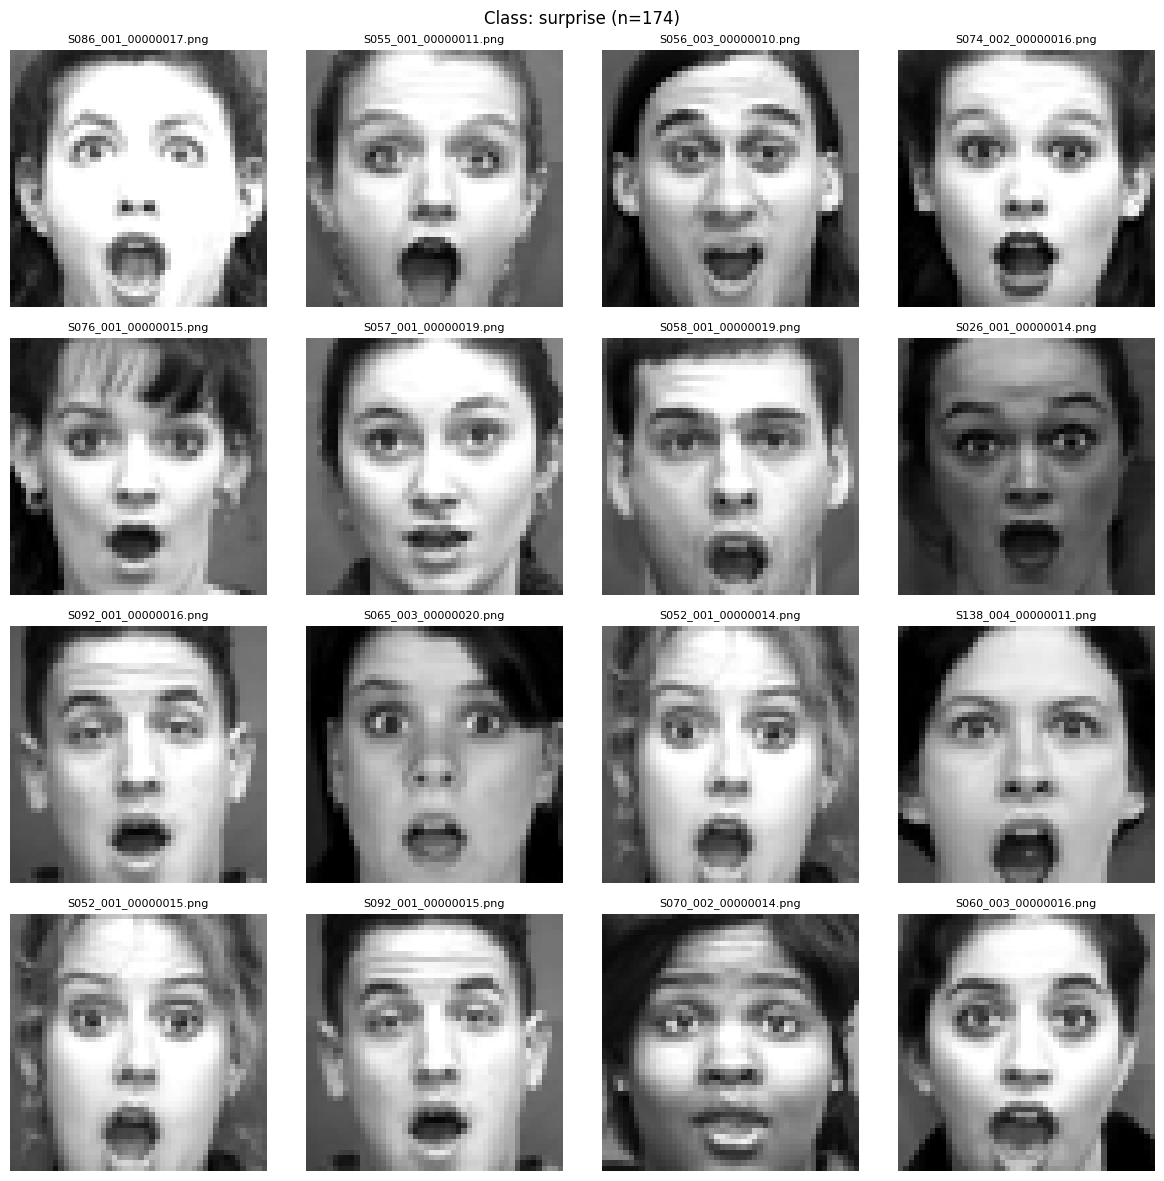

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(RANDOM_SEED)

def show_grid(paths, title, ncols=4, max_imgs=16):
    paths = paths[:max_imgs]
    n = len(paths)
    ncols = min(ncols, n) if n > 0 else ncols
    nrows = (n + ncols - 1) // ncols if n > 0 else 1

    plt.figure(figsize=(3*ncols, 3*nrows))
    for i, p in enumerate(paths):
        plt.subplot(nrows, ncols, i+1)
        try:
            img = Image.open(p).convert("RGB")
            plt.imshow(img)
            plt.axis("off")
            plt.title(p.name, fontsize=8)
        except Exception as e:
            plt.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center")
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for c in classes:
    subset = df[df["class"] == c]
    sample = subset.sample(n=min(SAMPLES_PER_CLASS, len(subset)), random_state=RANDOM_SEED)
    paths = sample["resolved_path"].tolist()
    show_grid(paths, title=f"Class: {c} (n={len(subset)})", ncols=4, max_imgs=SAMPLES_PER_CLASS)


Compute simple quality metrics to help find outliers.

We want quick, cheap signals that something is "off" in an image:
- brightness: too dark / too bright images often contain little usable facial detail
- contrast: very low contrast images look "washed out" and can be hard for the model
- blur: blurred images lose key expression cues (eyes/mouth edges)

In [12]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

def to_gray_np(img: Image.Image) -> np.ndarray:
    """
    Convert PIL image to grayscale (L) and return as float32 numpy array.
    Grayscale simplifies computing brightness/contrast/blur.
    """
    return np.array(img.convert("L"), dtype=np.float32)

def brightness(gray: np.ndarray) -> float:
    """
    Mean intensity in [0..255] for typical 8-bit images.
    Lower => darker image. Higher => brighter image.
    """
    return float(gray.mean())

def contrast(gray: np.ndarray) -> float:
    """
    Standard deviation of intensities.
    Low => flat/washed out image (little variation).
    High => more pronounced differences (edges stand out).
    """
    return float(gray.std())

def blur_score(gray: np.ndarray) -> float:
    """
    A simple blur proxy: variance of a Laplacian-like operator.
    - Sharp images have strong edges => high Laplacian variance.
    - Blurry images have weak edges => low Laplacian variance.

    We implement a basic Laplacian using rolls (no OpenCV needed).
    This is not as precise as OpenCV's Laplacian, but good enough for EDA.
    """
    lap = (
        -4 * gray
        + np.roll(gray, 1, axis=0) + np.roll(gray, -1, axis=0)
        + np.roll(gray, 1, axis=1) + np.roll(gray, -1, axis=1)
    )
    return float(lap.var())

def compute_metrics(resolved_paths, max_items=None):
    """
    Compute metrics for each image path.
    Returns a dataframe with columns:
      path, brightness, contrast, blur
    If an image fails to open/parse, we record an error instead.

    max_items is useful if you want to test on a smaller subset first.
    """
    rows = []
    items = resolved_paths if max_items is None else resolved_paths[:max_items]

    for p in tqdm(items, desc="Computing image metrics"):
        try:
            with Image.open(p) as im:
                g = to_gray_np(im)

            rows.append({
                "path": str(p),
                "brightness": brightness(g),
                "contrast": contrast(g),
                "blur": blur_score(g),
            })

        except Exception as e:
            rows.append({
                "path": str(p),
                "error": repr(e),
            })

    return pd.DataFrame(rows)

# Compute metrics for this dataset split
metrics_df = compute_metrics(df["resolved_path"].tolist())

# Separate clean rows from error rows
error_rows = metrics_df[metrics_df.get("error").notna()] if "error" in metrics_df.columns else metrics_df.iloc[0:0]
clean_m = metrics_df.dropna(subset=["brightness", "contrast", "blur"]).copy()

print("Total rows:", len(metrics_df))
print("Metric rows:", len(clean_m))
print("Error rows:", len(error_rows))
metrics_df.head()

Computing image metrics: 100%|██████████| 686/686 [00:00<00:00, 3889.88it/s]

Total rows: 686
Metric rows: 686
Error rows: 0


,path,brightness,contrast,blur
0,D:\Kebench\Documents\projects\xai-lab\data\raw...,120.154083,77.616936,1834.515625
1,D:\Kebench\Documents\projects\xai-lab\data\raw...,162.182724,96.221123,3802.710938
2,D:\Kebench\Documents\projects\xai-lab\data\raw...,137.832458,67.235199,2381.881836
3,D:\Kebench\Documents\projects\xai-lab\data\raw...,130.632385,78.732689,2132.487793
4,D:\Kebench\Documents\projects\xai-lab\data\raw...,113.165802,50.210403,1694.557251


Distributions + Outlier inspection with "signals"

**HISTOGRAMS**

In histograms, we're looking for:
1. a main "bulk" of images forming a cluster
2. a small tail of extreme values (these are outlier candidates)

Outlier signals often show up as:
- brightness histogram: a small tail near 0 (almost black) or near 255 (blown out)
- contrast histogram: a tail near 0 (washed-out / no detail)
- blur histogram: a tail near 0 (very blurry / no edges)

**OUTLIER HEURISTICS (NOT RULES)**

We can define outlier candidates using percentiles.

For example:
- darkest 1% images
- lowest-contrast 1% images
- blurriest (lowest blur score) 1% images

Why percentiles instead of fixed thresholds?

Because absolute values vary by dataset, camera, preprocessing, etc.

Percentiles adapt to whatever distribution you actually have.

**VISUALIZE OUTLIERS**

These functions display the images at the extremes so it can be manually judged:
- Are they genuinely bad?
- Or are they valid but just rare?

IMPORTANT: Do not blindly delete outliers.

Many "outliers" are still valid training examples (e.g., low light conditions).

Instead, decide:
- keep them and add augmentation to handle them,
- keep them but downweight / sample differently,
- remove if they are clearly corrupted / wrong / unusable.

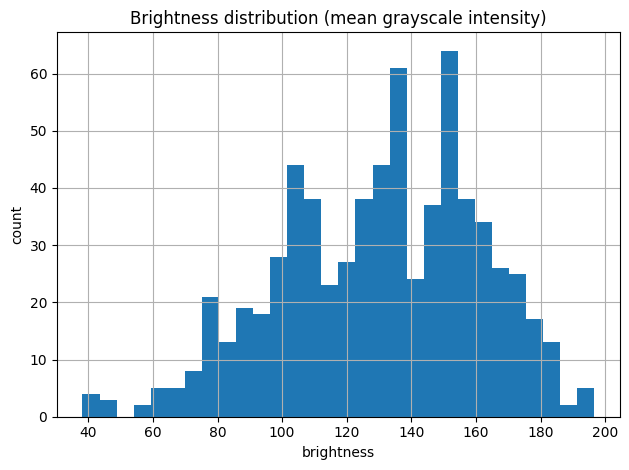

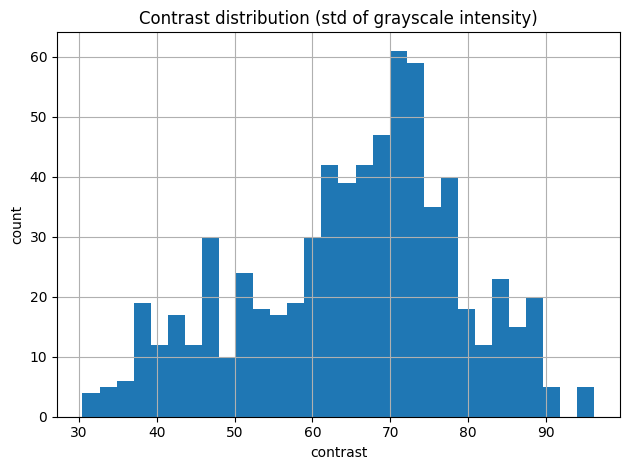

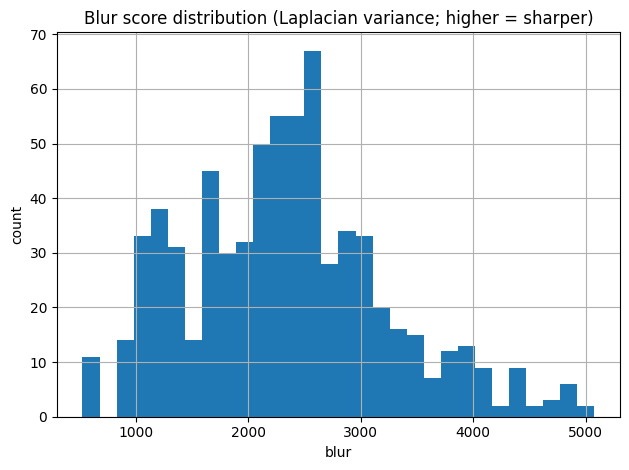

Outlier thresholds (percentile-based):
  brightness <= 57.04   (darkest 1%)
  brightness >= 184.90 (brightest 1%)
  contrast   <= 32.94   (lowest contrast 1%)
  blur       <= 635.14   (blurriest 1%)


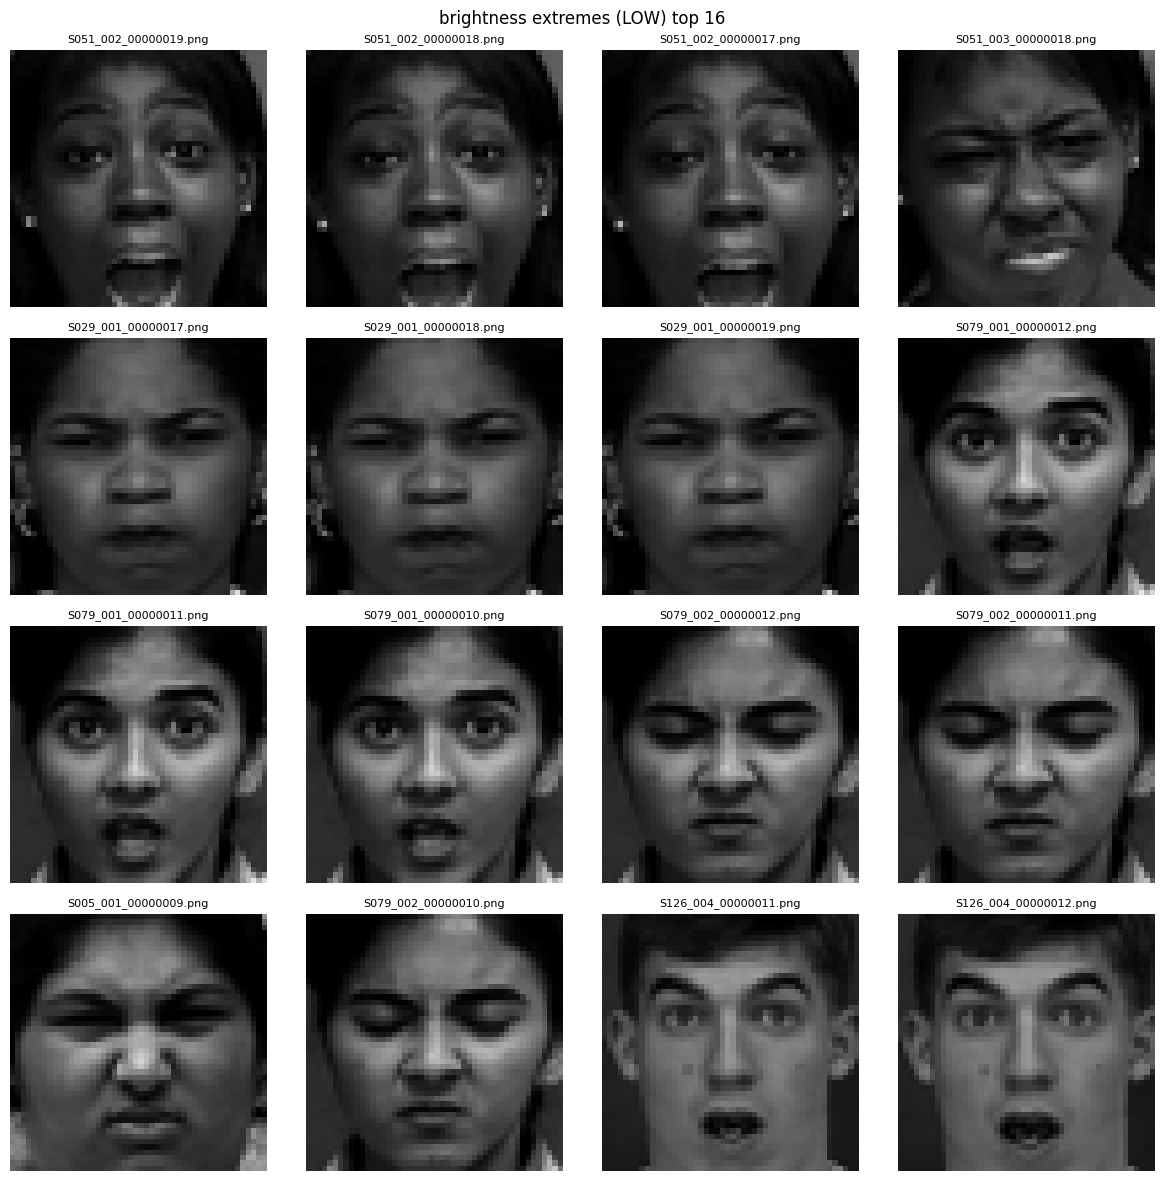

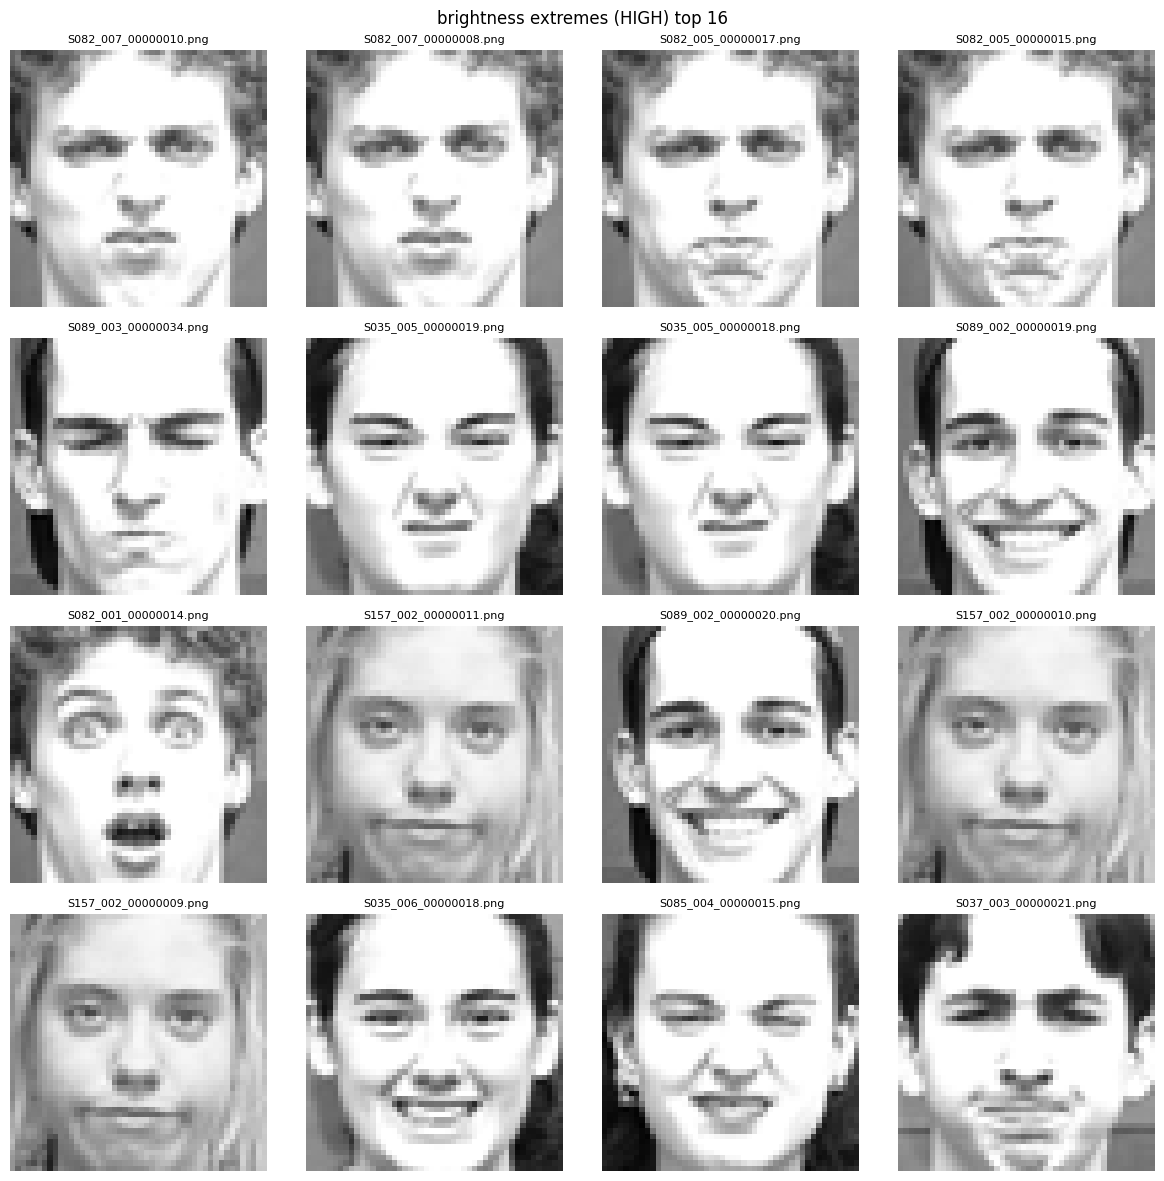

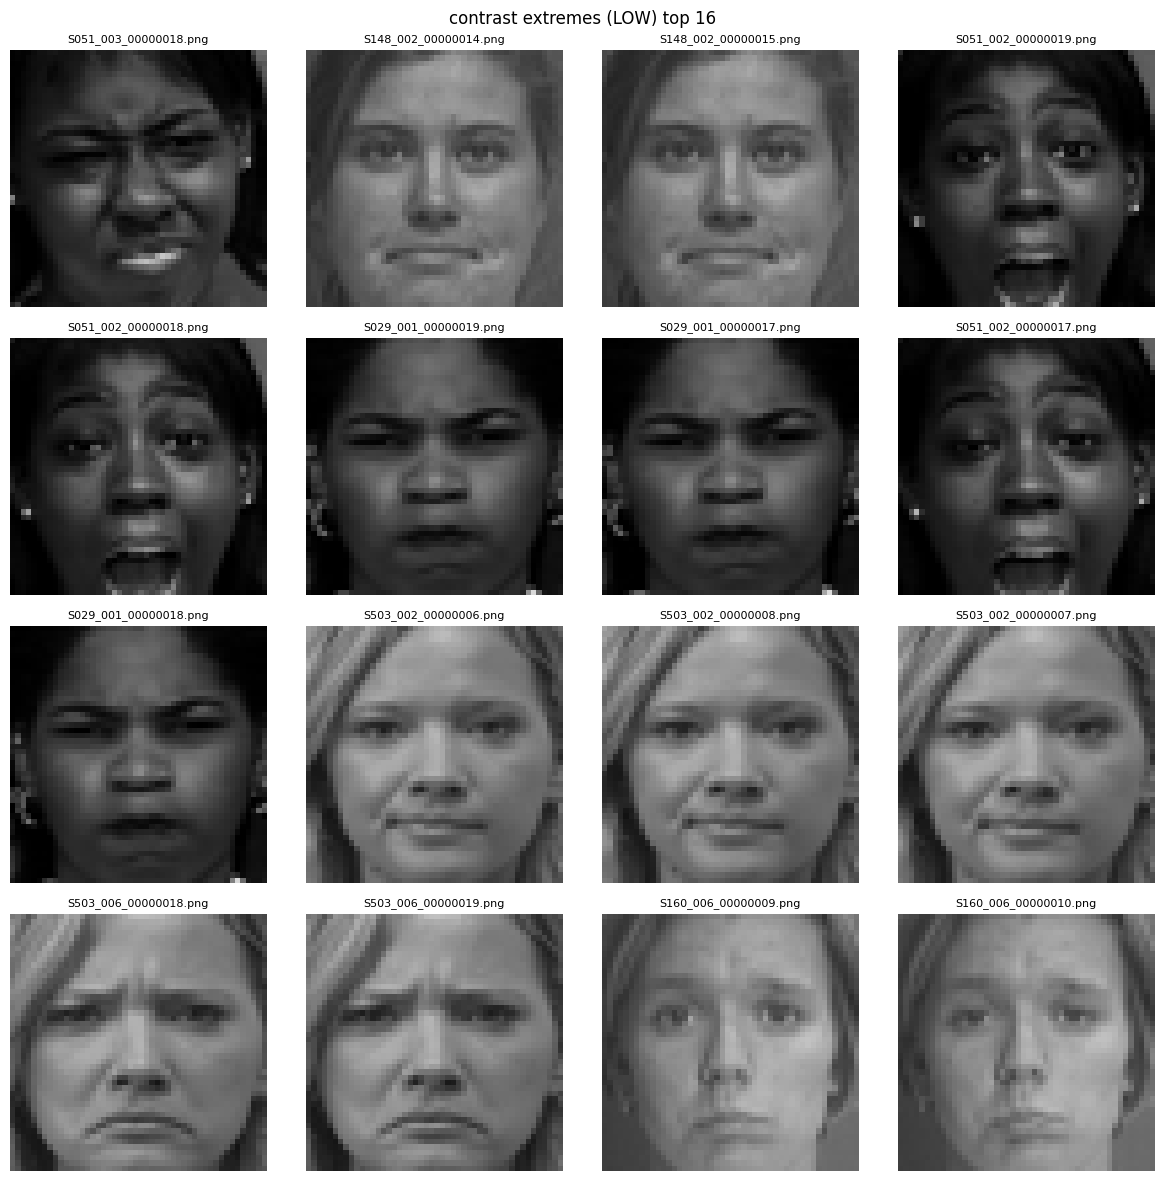

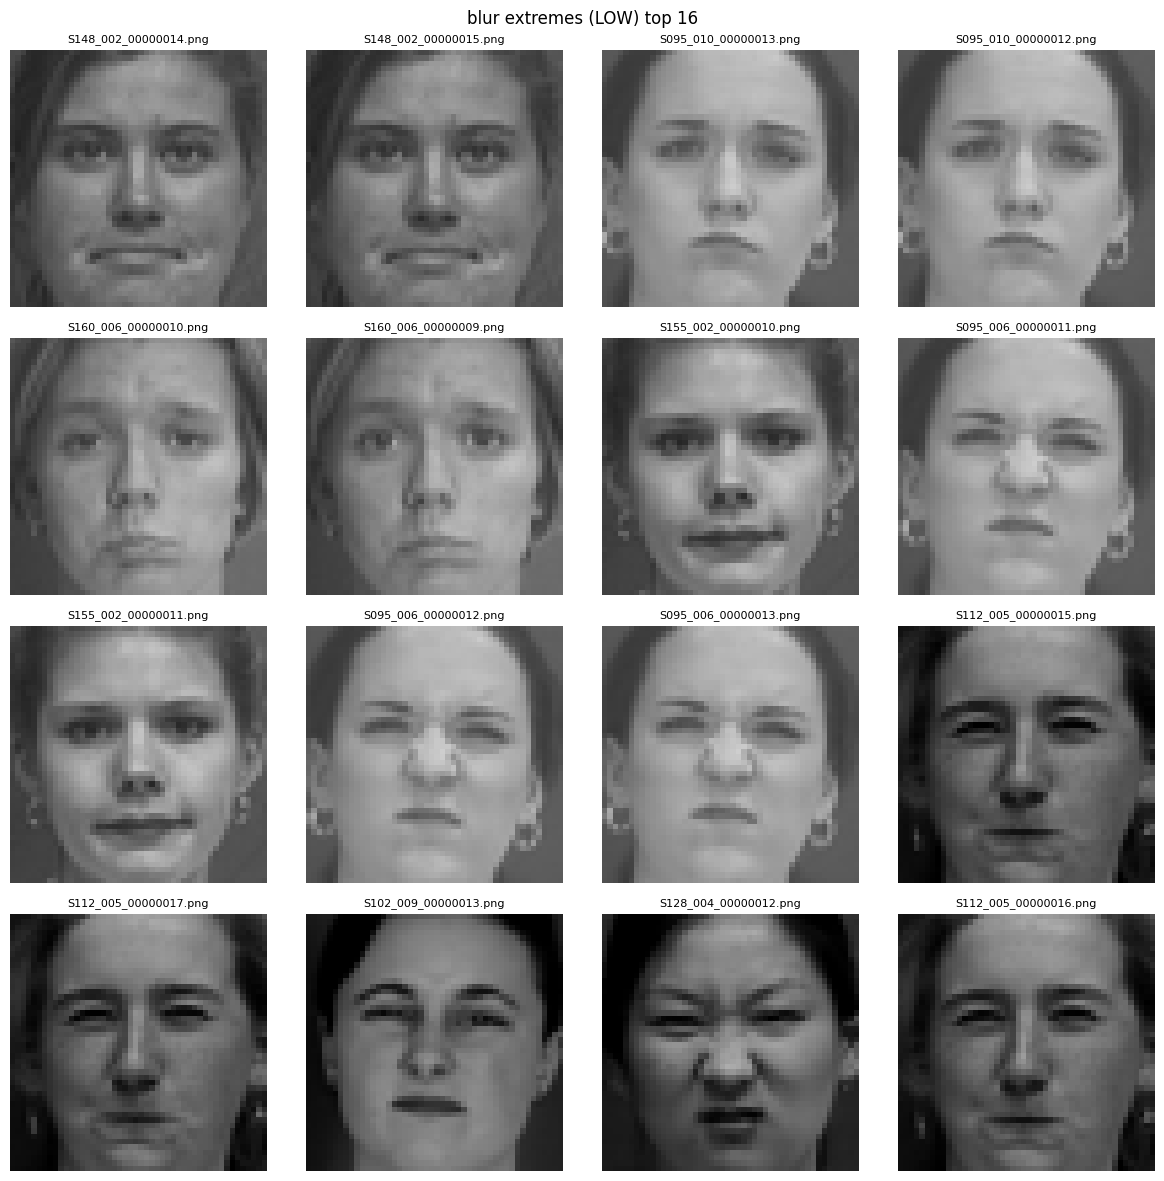

In [15]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_hist(series, title, bins=30):
    plt.figure()
    series.hist(bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

plot_hist(clean_m["brightness"], "Brightness distribution (mean grayscale intensity)")
plot_hist(clean_m["contrast"],   "Contrast distribution (std of grayscale intensity)")
plot_hist(clean_m["blur"],       "Blur score distribution (Laplacian variance; higher = sharper)")

def percentile_threshold(series, pct):
    return float(series.quantile(pct))

dark_thr   = percentile_threshold(clean_m["brightness"], 0.01)  # bottom 1%
bright_thr = percentile_threshold(clean_m["brightness"], 0.99)  # top 1%
lowc_thr   = percentile_threshold(clean_m["contrast"],   0.01)  # bottom 1%
blur_thr   = percentile_threshold(clean_m["blur"],       0.01)  # bottom 1% (blurry)

print("Outlier thresholds (percentile-based):")
print(f"  brightness <= {dark_thr:.2f}   (darkest 1%)")
print(f"  brightness >= {bright_thr:.2f} (brightest 1%)")
print(f"  contrast   <= {lowc_thr:.2f}   (lowest contrast 1%)")
print(f"  blur       <= {blur_thr:.2f}   (blurriest 1%)")

from PIL import Image

def show_grid(paths, title, ncols=4, max_imgs=16):
    paths = paths[:max_imgs]
    n = len(paths)
    ncols = min(ncols, n) if n > 0 else ncols
    nrows = (n + ncols - 1) // ncols if n > 0 else 1

    plt.figure(figsize=(3*ncols, 3*nrows))
    for i, p in enumerate(paths):
        plt.subplot(nrows, ncols, i+1)
        try:
            img = Image.open(Path(p)).convert("RGB")
            plt.imshow(img)
            plt.axis("off")
            plt.title(Path(p).name, fontsize=8)
        except Exception as e:
            plt.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center")
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_extremes(metric, n=16, smallest=True):
    sub = clean_m.sort_values(metric, ascending=smallest).head(n)
    direction = "LOW" if smallest else "HIGH"
    show_grid(sub["path"].tolist(), title=f"{metric} extremes ({direction}) top {n}", ncols=4, max_imgs=n)
    return sub

# Darkest images (often underexposed)
darkest = show_extremes("brightness", n=16, smallest=True)

# Brightest images (often overexposed / washed highlights)
brightest = show_extremes("brightness", n=16, smallest=False)

# Lowest contrast images (face detail may be weak)
lowest_contrast = show_extremes("contrast", n=16, smallest=True)

# Blurriest images (weak edges, motion blur, defocus)
blurriest = show_extremes("blur", n=16, smallest=True)


Interpreting percentile-based outlier thresholds

These thresholds are computed from the dataset’s own metric distributions. “1%” means only the most extreme ~1% of images fall beyond the cutoff (relative, not absolute).

- **brightness ≤ 57.04 (darkest 1%)**: mean grayscale intensity (0=black, 255=white). Images in this group are unusually underexposed/shadowed.
- **brightness ≥ 184.90 (brightest 1%)**: unusually bright/possibly overexposed images with potential loss of facial detail.
- **contrast ≤ 32.94 (lowest contrast 1%)**: grayscale std-dev. Very low contrast indicates flat/washed images where facial edges (eyes/mouth) are less distinct.
- **blur ≤ 635.14 (blurriest 1%)**: Laplacian-variance blur proxy. Lower values indicate weaker edges and more blur/defocus.

These cutoffs flag a small set of candidates for manual review (≈ 1% of the split per metric; for ~686 images, ~7 images). Valid but extreme samples can be kept with mild brightness/contrast augmentation; severely blurred/unusable samples may be removed or handled with robustness-focused augmentation later.


In [16]:
report_path = OUT_DIR / "notebook02_image_quality_metrics.csv"
clean_m.to_csv(report_path, index=False)
print("Saved:", report_path)

Saved: D:\Kebench\Documents\projects\xai-lab\artifacts\reports\eda\notebook02_image_quality_metrics.csv
